# <center>Final Project; Algorithms in Modern Statistics </center>
**Submitted by**: 
**<center>Full Names: Matan Mizrachi, Eyal Stolov</center>**

The following project is fully based on the data, that could be found and explained [here](https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students).

You might also need to run the next block.

In [ ]:
#!pip install plotly-express
#!pip install tqdm

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import ttest_ind, ttest_rel, mannwhitneyu, f_oneway

from itertools import combinations, permutations
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
tqdm.pandas()

## Useful Functions

### Plottings

In [2]:
def plot_decomposition(est, data: pd.DataFrame, color, dim=2, method='px', hover_data=None, marker=None,
                       exclude_dtypes=None, drop_color=False,
                       drop_columns=None, title='', return_estimator=False):
    _df = data.copy()
    if drop_columns:
        _df = _df.drop(columns=drop_columns)
    if exclude_dtypes:
        _df = _df.select_dtypes(exclude=exclude_dtypes)
    _df.loc[:, _df.dtypes == object] = _df.loc[:, _df.dtypes == object].progress_apply(lambda _z: _z.astype('category').cat.codes)
    color = _df[color].copy() if method == 'plt' else data[color].copy()
    _df = _df.drop(columns = [color.name]) if color.name in _df.columns and drop_color else _df

    est = est.fit(StandardScaler().fit_transform(_df))
    _x = est.transform(StandardScaler().fit_transform(_df))
    
    dim_cols = [f'PC{i} : Most Important - {_df.columns[np.abs(est.components_[i-1]).argmax()]}' for i in range(1, dim+1)]
    _x = pd.DataFrame(_x[:, :dim], columns=dim_cols)
    
    if hover_data:
        if type(hover_data) == str:
            hover_data = [hover_data]
        _x[hover_data] = data[hover_data]
    else:
        hover_data = _df.columns
        _x[hover_data] = data[hover_data]

    _x[color.name] = color
    
    if dim == 2:      
        if method == 'px':
            fig = px.scatter(_x, x=dim_cols[0], y=dim_cols[1], color=color.name, hover_data=hover_data, symbol=marker)
        elif method == 'plt':
            cax = plt.scatter(_x[dim_cols[0]], _x[dim_cols[1]], c=color)
            plt.xlabel(dim_cols[0])
            plt.ylabel(dim_cols[1])

    elif dim == 3:
        if method == 'px':
            fig = px.scatter_3d(_x, x=dim_cols[0], y=dim_cols[1], z=dim_cols[2], color=color.name, 
                                hover_data=hover_data, symbol=marker)
        elif method == 'plt':
            ax = plt.axes(projection='3d')
            cax = ax.scatter(_x[dim_cols[0]], _x[dim_cols[1]], _x[dim_cols[2]], c=color, marker='o')
            plt.xlabel(dim_cols[0])
            plt.ylabel(dim_cols[1])
            ax.set_zlabel(dim_cols[2])
    if method == 'px':
        fig.update_layout(
            title={
                'text': title,
                'x': 0.5,
                'y': 0.95,
                'xanchor': 'center',
                'yanchor': 'top'}, coloraxis_colorbar=dict(yanchor="top", x=-0.25,y=1))
        
        fig.show()
    else:
        plt.title(title)
        plt.colorbar(cax, ticks=np.unique(color))
        plt.show()
    if return_estimator:
        return est
    

def biplot(est, data, method='plt'):
    _df = data.copy()
    _df.loc[:, _df.dtypes == object] = _df.loc[:, _df.dtypes == object].progress_apply(lambda _z: _z.astype('category').cat.codes)
    feature_names = _df.columns
    est = est.fit(StandardScaler().fit_transform(_df))
    loadings = est.components_.T * np.sqrt(est.explained_variance_)
    
    for i, (_x, _y) in enumerate(loadings):
        if method == 'plt':
            plt.annotate(feature_names[i], (0, 0), (_x , _y), arrowprops = {'arrowstyle': '<-', 'color': 'black'})
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()

### DataFrame Transformations

In [10]:
def split_xy(data: pd.DataFrame, by: str, x: str = None):
    new_df = []
    for _val in data[by].unique():
        if x is not None:
            new_df.append(data.loc[data[by] == _val, x].copy().reset_index(drop=True))
        else:
            new_df.append(data.loc[data[by] == _val].copy().reset_index(drop=True))
    return new_df

def corr_categorical(data, features):
    _df = data.copy()
    _df[features] = _df[features].progress_apply(lambda _z: _z.astype('category').cat.codes)
    
    return _df[features].corr()

In [3]:
df = pd.read_csv('archive/test_scores.csv')
df['lunch'] = df['lunch'].apply(lambda _z: _z if _z == 'Does not qualify' else 'Qualifies')
df.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


## Part 1: EDA
The following part contains of:
- Data Visualizations
- General Statistics of Each Feature
- Visualizing Relationships Between Features
- Dimensionality Reduction

### Categorical Data

In [5]:
df.describe(include='object')

,school,school_setting,school_type,classroom,teaching_method,student_id,gender,lunch
count,2133,2133,2133,2133,2133,2133,2133,2133
unique,23,3,2,97,2,2133,2,2
top,GOOBU,Urban,Public,18K,Standard,2FHT3,Male,Does not qualify
freq,158,906,1582,31,1373,1,1077,1215


Based on the tables above, we can basically dismiss the *student_id* feature, as its variety leads to no valuable information to be gained out of it.

In [4]:
df = df.drop(columns=['student_id'])

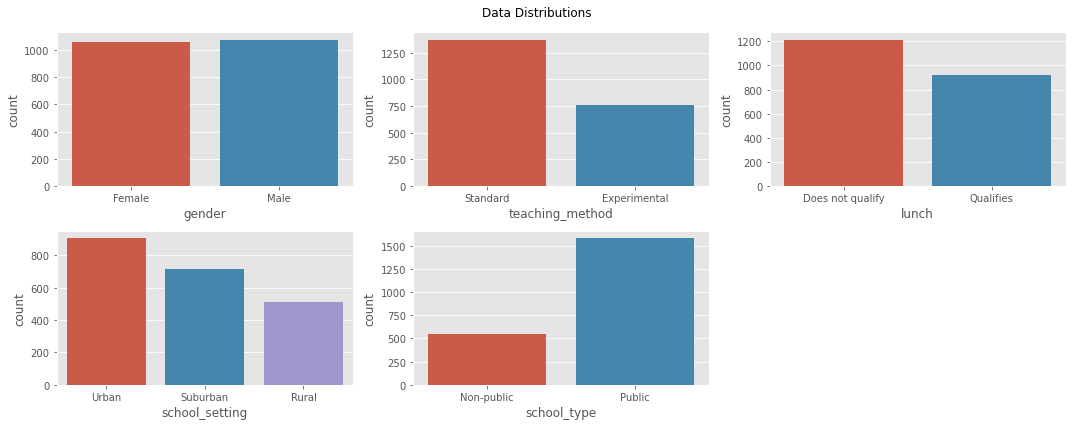

In [5]:
plt.figure(figsize=(15, 6))
plt.suptitle('Data Distributions')
for i, c in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    plt.subplot(2, 3, i+1)
    sns.countplot(df[c])
plt.tight_layout()
plt.show()

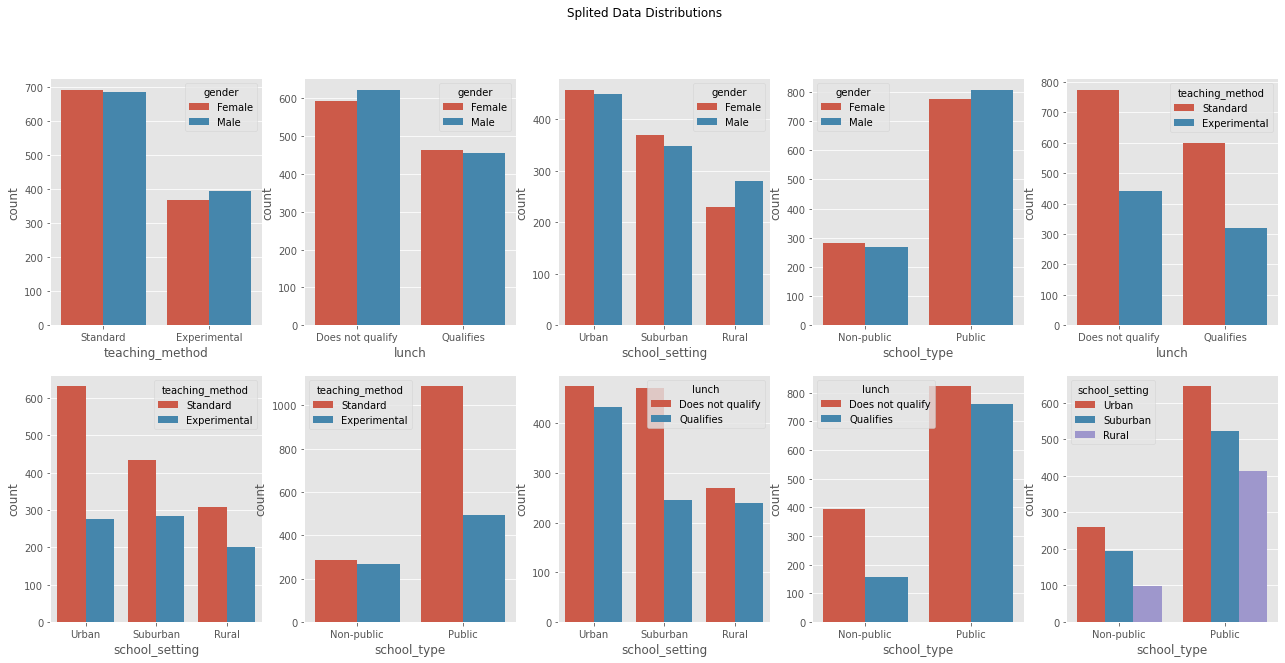

In [6]:
plt.figure(figsize=(22, 10))
plt.suptitle('Splited Data Distributions')
index = 1
for i, hue in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    for j, col in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
        if j <= i:
            continue
        plt.subplot(2, 5, index)
        index += 1
        sns.countplot(data=df, x=col, hue=hue)
plt.show()

We can already see differences in some of the features distributions when dividing them into separated groups;
- School type, divided by teaching method
- School type, divided by *lunch* feature
- Genders in different school settings

### Numeric Data

In [7]:
df.describe()

,n_student,pretest,posttest
count,2133.000000,2133.000000,2133.000000
mean,22.796531,54.955931,67.102203
std,4.228893,13.563101,13.986789
min,14.000000,22.000000,32.000000
25%,20.000000,44.000000,56.000000
50%,22.000000,56.000000,68.000000
75%,27.000000,65.000000,77.000000
max,31.000000,93.000000,100.000000


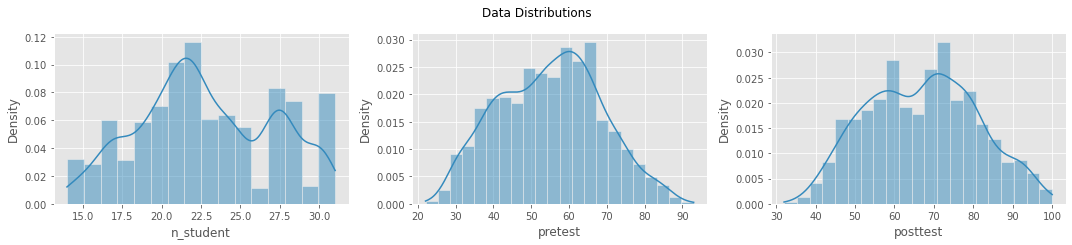

In [8]:
plt.figure(figsize=(15, 6))
plt.suptitle('Data Distributions')
for i, c in enumerate(['n_student', 'pretest', 'posttest']):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=c, kde=True, stat='density', ax=plt.gca())
plt.tight_layout()
plt.show()

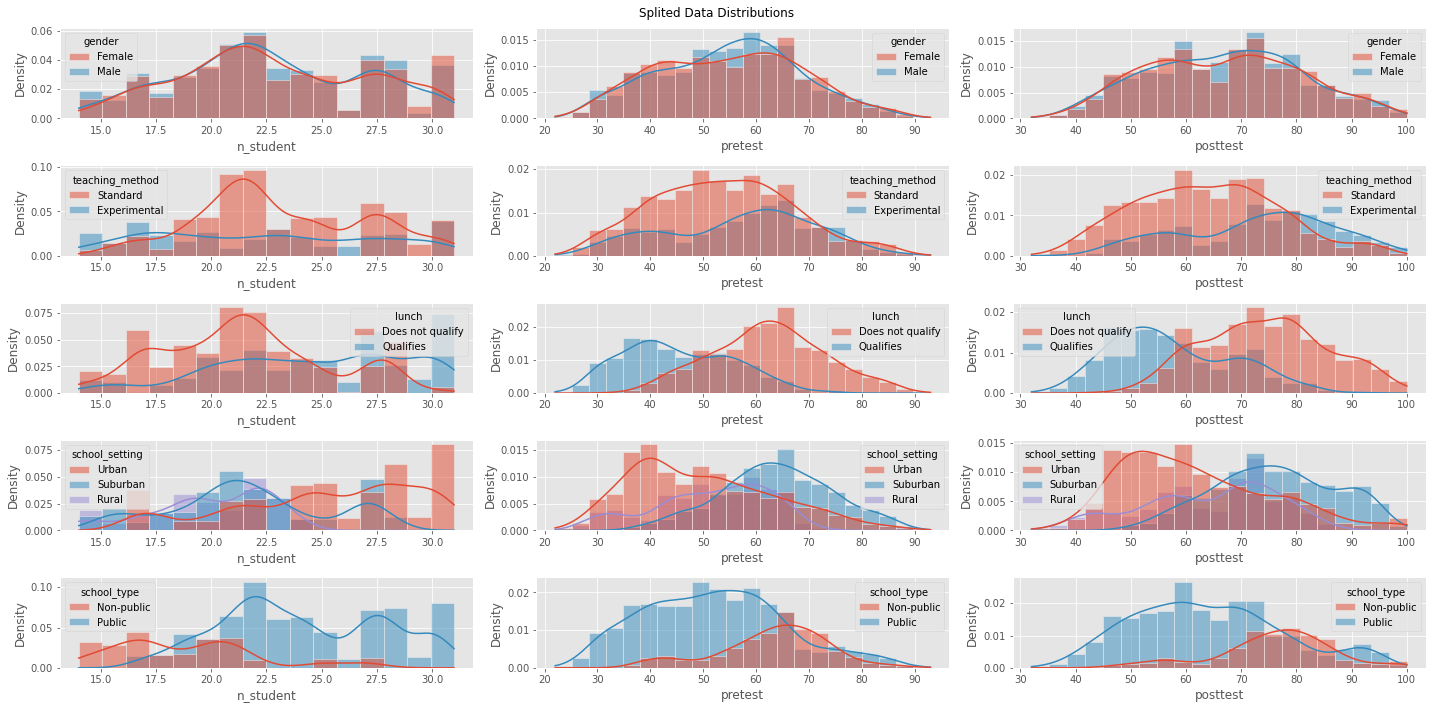

In [11]:
plt.figure(figsize=(20, 10))
plt.suptitle('Splited Data Distributions')
index = 1
for i, hue in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    for j, col in enumerate(['n_student', 'pretest', 'posttest']):
        plt.subplot(5, 3, index)
        index += 1
        sns.histplot(data=df, x=col, hue=hue, kde=True, stat='density', ax=plt.gca())
plt.tight_layout()
plt.show()

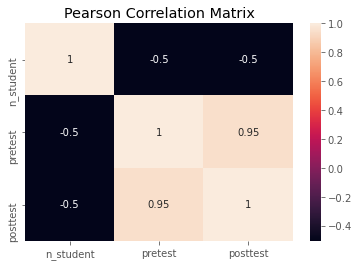

In [12]:
sns.heatmap(df[['n_student', 'pretest', 'posttest']].corr(), annot=True)
plt.title('Pearson Correlation Matrix')
plt.show()

Clearly, the pretest and posttest scores are very highly correlated, almost as if these were the same features to work with.


In [5]:
df = df.drop(columns=['pretest'])

Another interesting thing to investigate is whether the number of students in a class affects, significantly, the class GPA.

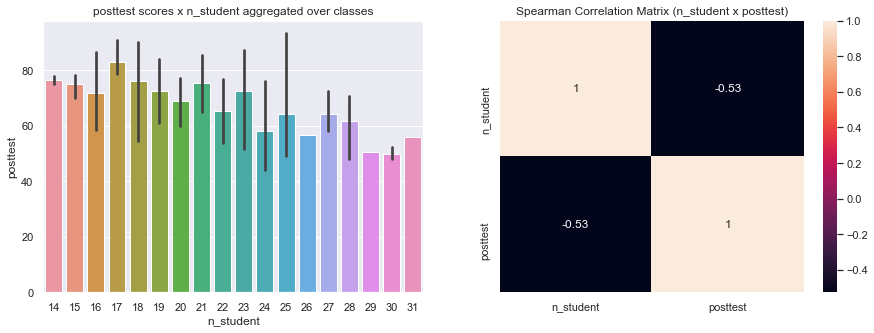

In [9]:
plt.subplot(1, 2, 1)
plt.title('posttest scores x n_student aggregated over classes')
t_df = df.groupby('classroom').mean()
t_df['n_student'] = t_df['n_student'].astype(int)
sns.set_theme(rc={'figure.figsize':(15,5)})
sns.barplot(data=t_df,x='n_student',y='posttest',ci=100)

plt.subplot(1, 2, 2)
plt.title('Spearman Correlation Matrix (n_student x posttest)')
sns.heatmap(t_df[['n_student', 'posttest']].corr(method='spearman'), annot=True)

plt.show()

t_df = None
del(t_df)

We can see that the GPA of classes with 23 students or less are above 60 (passing grade). However, the spearman correlation coefficient between the two groups seems to be very low. We can have an hypothesis test on whether the difference of GPA between classes of 23 and less students is significant of class with 24 and more students.

In [28]:
est = plot_decomposition(est=PCA(n_components=2, svd_solver='full'), data=df, color='school_type', marker='lunch',
                         return_estimator=True, title='PCA over Numeric Data', dim=2,
                         drop_columns=['school', 'classroom'], drop_color=False, exclude_dtypes=None)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

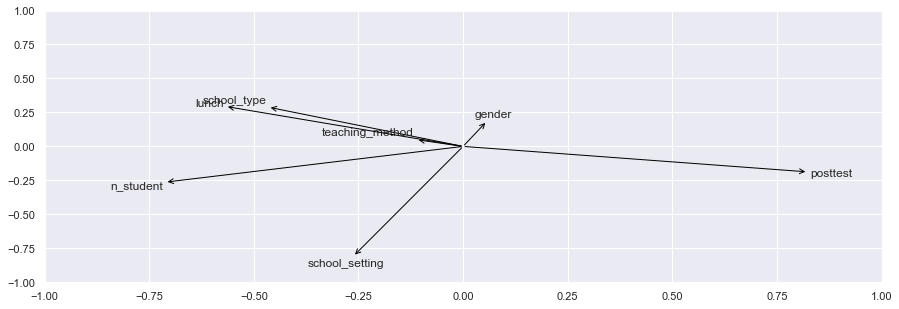

In [8]:
biplot(PCA(n_components=2, svd_solver='full'), df.drop(columns=['classroom', 'school']))

## Part 2: Hypothesis Testing

Next, we can question whether the differences, of posttest scores, between students that qualifies to free lunch and those that do not, are significant.

In [25]:
a, b = split_xy(df, 'school_type', 'posttest')
print(mannwhitneyu(a, b),'\n')

MannwhitneyuResult(statistic=208085.5, pvalue=4.379396959105047e-75) 



In [22]:
len(a), len(b)

(551, 1582)